# Training and validating the final model with 5-fold cross validation

### Importing Libraries

In [269]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, roc_curve, precision_recall_curve)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

from statsmodels.stats.multitest import multipletests

import copy

In [270]:
torch.cuda.is_available()

True

### Preparing core data

In [271]:
data = pd.read_csv(f"https://raw.githubusercontent.com/JackWJW/LGG_Prognosis_Prediction/main/Tidied_Datasets/tidied_integrated_df_13.csv").drop(columns=["Unnamed: 0"])
dss_info = data[["DSS", "DSS.time"]]

X = data.drop(columns=["Srv", "DSS", "DSS.time"])
y = LabelEncoder().fit_transform(data["Srv"])

### Preparing Focal Loss Function for the ANN with Best Params

In [272]:
class FocalLoss(nn.Module):
    """
    Binary focal loss for logits.
    """
    def __init__(self, alpha=0.35, gamma=2.1, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        targets = targets.view(-1, 1).type_as(logits)  # Make sure targets are (batch, 1) and same type as logits
        bce_loss = nn.functional.binary_cross_entropy_with_logits(
            logits, targets, reduction='none'
        )

        # Compute pt
        pt = torch.exp(-bce_loss)

        # Apply focal term
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


### Preparing ANN Model with Best Params

In [273]:
class DeepBinary(nn.Module):
    """
    Deep feedforward model for binary classification (outputs logits).
    """
    def __init__(self, input_dim, hidden_dim=165, num_layers=4, dropout_rate=0.75):
        super().__init__()
        layers = []
        in_dim = input_dim

        for _ in range(num_layers):
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_dim = hidden_dim

        # Final output layer — raw logits (no sigmoid here!)
        layers.append(nn.Linear(hidden_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)  # raw logits

### Defining the ANN Model Training Function

In [274]:
# === Deep model training function ===
def model_train(model, X_train, y_train, X_val, y_val):
    # Ensure PyTorch tensors
    if isinstance(X_train, np.ndarray):
        X_train = torch.tensor(X_train, dtype=torch.float32)
    if isinstance(y_train, np.ndarray):
        y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    if isinstance(X_val, np.ndarray):
        X_val = torch.tensor(X_val, dtype=torch.float32)
    if isinstance(y_val, np.ndarray):
        y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    loss_fn = FocalLoss(alpha=0.35, gamma=2.1)
    optimizer = optim.Adam(model.parameters(), lr=0.03)
    n_epochs = 300
    batch_size = 128

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=len(y_val), shuffle=False)

    best_acc = -np.inf
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                logits = model(X_val_batch)
                probs  = torch.sigmoid(logits)
                preds  = (probs >= 0.5).float()
                acc    = (preds == y_val_batch).float().mean()
                if acc > best_acc:
                    best_acc = acc
                    best_weights = copy.deepcopy(model.state_dict())

    model.load_state_dict(best_weights)
    model.eval()

    with torch.no_grad():
        logits = model(X_val)
        probs  = torch.sigmoid(logits).cpu().numpy().flatten()   # probabilities in [0,1]
        y_true = y_val.cpu().numpy().flatten().astype(int)
        y_pred = (probs >= 0.5).astype(int)

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, probs),
            'pr_auc': average_precision_score(y_true, probs),
        }

        fpr, tpr, _ = roc_curve(y_true, probs)
        precision, recall, _ = precision_recall_curve(y_true, probs)

        return metrics, (fpr, tpr), (precision, recall), y_true, probs

### Preparing Cross Validation Functions

In [275]:
def run_cv(ModelClass):
    metrics_list, roc_curves, pr_curves, fold_probs, fold_survival = [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):    
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        dss_train, dss_val = dss_info.iloc[train_idx], dss_info.iloc[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        oversample = SMOTE()
        X_train_res, y_train_res = oversample.fit_resample(X_train_scaled, y_train)

        model = ModelClass()
        m, roc, pr, y_true, y_pred_probs = model_train(
            model, X_train_res, y_train_res, X_val_scaled, y_val
        )

        # Store for ROC/PR
        fold_probs.append({
            "y_true": y_true,
            "y_pred_probs": y_pred_probs,
            "dss_time": dss_val["DSS.time"].values,
            "dss_event": dss_val["DSS"].values
        })

        # Store for KM plots
        y_pred = (y_pred_probs >= 0.5).astype(int)
        fold_survival.append((dss_val, y_pred))

        metrics_list.append(m)
        roc_curves.append(roc)
        pr_curves.append(pr)

        print(f"Fold {fold+1} (Deep): Accuracy={m['accuracy']:.2f}, "
              f"F1={m['f1']:.2f}, AUC={m['roc_auc']:.2f}")

    return metrics_list, roc_curves, pr_curves, fold_probs, fold_survival


def run_cv_sklearn(ModelClass, model_name):
    metrics_list, roc_curves, pr_curves, fold_probs, fold_survival = [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        dss_train, dss_val = dss_info.iloc[train_idx], dss_info.iloc[val_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        oversample = SMOTE()
        X_train_res, y_train_res = oversample.fit_resample(X_train_scaled, y_train)

        model = ModelClass()
        model.fit(X_train_res, y_train_res.ravel())

        y_pred_probs = model.predict_proba(X_val_scaled)[:, 1]
        y_pred = (y_pred_probs >= 0.5).astype(int)
        y_true = y_val.flatten()

        fold_probs.append({
            "y_true": y_true,
            "y_pred_probs": y_pred_probs,
            "dss_time": dss_val["DSS.time"].values,
            "dss_event": dss_val["DSS"].values
        })

        fold_survival.append((dss_val, y_pred))

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, y_pred_probs),
            'pr_auc': average_precision_score(y_true, y_pred_probs)
        }

        fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
        precision, recall, _ = precision_recall_curve(y_true, y_pred_probs)

        metrics_list.append(metrics)
        roc_curves.append((fpr, tpr))
        pr_curves.append((precision, recall))

        print(f"Fold {fold+1} ({model_name}): Accuracy={metrics['accuracy']:.2f}, "
              f"F1={metrics['f1']:.2f}, AUC={metrics['roc_auc']:.2f}")

    return metrics_list, roc_curves, pr_curves, fold_probs, fold_survival


def run_cv_ensemble_from_probs(fold_prob_dict, strategy="mean"):
    metrics_list, roc_curves, pr_curves, fold_probs, fold_survival = [], [], [], [], []

    for fold in range(len(next(iter(fold_prob_dict.values())))):
        y_true = None
        probs = []
        dss_time, dss_event, dss_val = None, None, None

        for model_name, folds in fold_prob_dict.items():
            fold_data = folds[fold]
            probs.append(fold_data["y_pred_probs"])
            if y_true is None:
                y_true = fold_data["y_true"]
                dss_time = fold_data["dss_time"]
                dss_event = fold_data["dss_event"]
                dss_val = pd.DataFrame({
                    "DSS.time": dss_time,
                    "DSS": dss_event
                })

        if strategy == "mean":
            ensemble_probs = np.mean(probs, axis=0)
        elif strategy == "max":
            ensemble_probs = np.max(probs, axis=0)
        else:
            raise ValueError("strategy must be 'mean' or 'max'")

        y_pred = (ensemble_probs >= 0.5).astype(int)

        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'roc_auc': roc_auc_score(y_true, ensemble_probs),
            'pr_auc': average_precision_score(y_true, ensemble_probs)
        }

        fpr, tpr, _ = roc_curve(y_true, ensemble_probs)
        precision, recall, _ = precision_recall_curve(y_true, ensemble_probs)

        metrics_list.append(metrics)
        roc_curves.append((fpr, tpr))
        pr_curves.append((precision, recall))

        fold_probs.append({
            "y_true": y_true,
            "y_pred_probs": ensemble_probs,
            "dss_time": dss_time,
            "dss_event": dss_event
        })

        fold_survival.append((dss_val, y_pred))

    return metrics_list, roc_curves, pr_curves, fold_probs, fold_survival

### Preparing Analysis and Plotting Functions

In [276]:
def compute_mean_curve(curves):
    """
    curves: list of (x, y) arrays from folds
    Returns mean_x, mean_y interpolated over [0, 1]
    """
    all_x = np.linspace(0, 1, 100)
    all_y = [np.interp(all_x, c[0], c[1]) for c in curves]
    mean_y = np.mean(all_y, axis=0)
    return all_x, mean_y

def summarize_metrics(metrics_list):
    summary = {}
    for k in metrics_list[0].keys():
        vals = [m[k] for m in metrics_list]
        summary[k] = (np.mean(vals), np.std(vals))
    return summary

def print_summary(name, summary):
    print(f"\n{name} Model Summary:")
    for k, (mean, std) in summary.items():
        print(f"{k}: {mean:.3f} ± {std:.3f}")

def plot_mean_roc(curves_summary, metrics_dict):
    """
    curves_summary["roc"][model] = (fpr, mean_tpr)
    metrics_dict[model] = list of per-fold metrics (dicts with "roc_auc")
    """
    plt.figure(figsize=(7, 6))
    for model_name, (fpr, mean_tpr) in curves_summary["roc"].items():
        mean_auc = np.mean([m["roc_auc"] for m in metrics_dict[model_name]])
        plt.plot(fpr, mean_tpr, label=f"{model_name} (AUC={mean_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison (Mean across folds)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_mean_pr(curves_summary, metrics_dict):
    """
    curves_summary["pr"][model] = (recall, mean_precision)
    metrics_dict[model] = list of per-fold metrics (dicts with "ap")
    """
    plt.figure(figsize=(7, 6))
    for model_name, (recall, mean_prec) in curves_summary["pr"].items():
        mean_ap = np.mean([m["pr_auc"] for m in metrics_dict[model_name]])
        plt.plot(recall, mean_prec, label=f"{model_name} (AP={mean_ap:.2f})")
    plt.hlines(y.sum()/len(y), 0, 1, colors="k", linestyles="--", label="Baseline")  
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve Comparison (Mean across folds)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_km_curves(survival_results, max_years=5):
    """
    survival_results[model_name] = list of (dss_val_df, pred_class_array) per fold
    Each dss_val_df has columns: DSS.time, DSS
    pred_class_array = binary predictions (0/1)
    """
    risk_labels = {0: "Low Risk", 1: "High Risk"}
    model_list = list(survival_results.keys())
    colours = ["#C190F0", "#35AB6A"]

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    logrank_ps = []
    iteration = 0
    for idx, model_name in enumerate(model_list):
        ax = axes[idx]

        # Pool all folds
        dfs = []
        for dss_val, pred_class in survival_results[model_name]:
            temp = dss_val.copy()
            temp["pred_class"] = pred_class
            dfs.append(temp)
        pooled_df = pd.concat(dfs, ignore_index=True)

        high = pooled_df[pooled_df["pred_class"] == 1]
        low  = pooled_df[pooled_df["pred_class"] == 0]
        lr_res = logrank_test(
            high["DSS.time"], low["DSS.time"],
            event_observed_A=high["DSS"], event_observed_B=low["DSS"]
        )
        p_val = lr_res.p_value
        logrank_ps.append(p_val)
        fdr_vals = multipletests(logrank_ps, method="fdr_bh")[1]
        ax.set_title(f"{model_name}\nLog-Rank p FDR = {fdr_vals[iteration]:.2e}", fontsize=14)
        iteration += 1
        # KM curves
        kmf = KaplanMeierFitter()
        for cls in [0, 1]:
            mask = pooled_df["pred_class"] == cls
            n_value = mask.sum()
            kmf.fit(
                durations=pooled_df.loc[mask, "DSS.time"] / 365,
                event_observed=pooled_df.loc[mask, "DSS"],
                label=f"{risk_labels[cls]} (n={n_value})"
            )
            kmf.plot_survival_function(ax=ax, ci_show=True, color=colours[cls])

        ax.set_xlim(0, max_years)
        ax.set_xlabel("Time (years)", fontsize=12)
        ax.set_ylabel("Survival probability", fontsize=12)
        ax.tick_params(axis="both", labelsize=10)
        ax.legend(fontsize=10,loc="lower left",edgecolor="black")

    # Remove unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_forest(survival_results, metrics_df):
    results = []
    survival_results_2 = {"Ensemble" if k == 'Ensemble (Mean)' else k:v for k,v in survival_results.items()}
    print(survival_results_2.keys())
    model_list = list(survival_results_2.keys())
    for idx, model_name in enumerate(model_list):
        # Pool all folds
        dfs = []
        for dss_val, pred_class in survival_results_2[model_name]:
            temp = dss_val.copy()
            temp["pred_class"] = pred_class
            dfs.append(temp)
        pooled_df = pd.concat(dfs, ignore_index=True)

        # Cox PH model
        cph_df = pooled_df.rename(columns={"DSS.time": "time", "DSS": "event"})
        cph = CoxPHFitter()
        cph.fit(cph_df, duration_col="time", event_col="event")
        summary = cph.summary.loc["pred_class"]
        results.append({
            'Model':model_name,
            'HR': summary['exp(coef)'],
            'CI_lower': summary['exp(coef) lower 95%'],
            'CI_upper': summary['exp(coef) upper 95%'],
            'p': summary['p']
        })
        sig_df = pd.DataFrame(results)
        sig_df = pd.merge(sig_df,metrics_df, on="Model")
        sig_df["FDR"] = multipletests(sig_df["p"], method="fdr_bh")[1]
        sig_df["Sig"] = sig_df["FDR"] < 0.05
    

    df_forest = sig_df.copy().sort_values(by="HR")

    fig, ax = plt.subplots(figsize=(14,6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 4], wspace=-0.065)
    ax = fig.add_subplot(gs[0])

    ax.errorbar(df_forest["HR"], df_forest["Model"],
                xerr=[df_forest["HR"] - df_forest["CI_lower"], df_forest["CI_upper"] - df_forest["HR"]],
                fmt='none', ecolor='black', capsize=5, elinewidth=1.5, capthick=1.5,zorder=1)

    scatter = ax.scatter(df_forest["HR"], df_forest["Model"],
                            c=df_forest["Sig"], cmap='Set2_r',
                            linewidths=1.5, edgecolors='black',
                            zorder=2,vmin=0,s=150)
    ax.invert_yaxis()
    ax.axvline(1, color='red', linestyle='--')
    ax.set_xlim(0,10)
    ax.set_title(f"Forest Plot",fontsize=16,fontweight='bold')
    ax.set_xlabel("Hazard Ratio (HR)",fontsize=16)
    ax.tick_params(axis='both',labelsize=14)
    ax.set_xticks(ticks=[0,2,4,6,8,10],labels=[0,2,4,6,8,10])
    ax_table = fig.add_subplot(gs[1],sharey=ax)
    ax_table.set_axis_off()
    headers = ["HR", "FDR", "ACC", "PRC", "REC", "F1", "ROC", "AP"]
    col_x = np.linspace(0, 1, len(headers))

    for x, h in zip(col_x, headers):
        ax_table.text(x, -0.3, h, fontsize=14, fontweight="bold",
                    ha="center", va="bottom")

    # Add rows aligned with forest plot
    for row_idx, row in enumerate(df_forest.itertuples(), start=0):
        values = [f"{row.HR:.2f}", f"{row.FDR:.2e}", f"{row.accuracy_mean:.2f}\u00B1{row.accuracy_std:.2f}",
                f"{row.precision_mean:.2f}\u00B1{row.precision_std:.2f}", f"{row.recall_mean:.2f}\u00B1{row.recall_std:.2f}",
                f"{row.f1_mean:.2f}\u00B1{row.f1_std:.2f}", f"{row.roc_auc_mean:.2f}\u00B1{row.roc_auc_std:.2f}", f"{row.pr_auc_mean:.2f}\u00B1{row.pr_auc_std:.2f}"]
        for x, val in zip(col_x, values):
            ax_table.text(x, row_idx, val,
                        fontsize=12, ha="center", va="center")
    
    y_positions = range(0,5)

    for y in y_positions:
        ax.hlines(y + 0.5, xmin=0, xmax=10,
                colors='lightgray', linestyles='--', linewidth=1, zorder=0)
        
        ax_table.hlines(y + 0.5, xmin=-0.035, xmax=1.065,
                        colors='lightgray', linestyles='--', linewidth=1, zorder=0)

    for extra_ax in fig.get_axes():
        if extra_ax not in [ax, ax_table]:
            extra_ax.remove()

    plt.show()


### Preparing stratification

In [277]:
# Defining stratification
kfold = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

### Running Models

In [278]:
# Run CV for all models
deep_metrics, deep_roc, deep_pr, deep_probs, deep_survival = run_cv(lambda: DeepBinary(X.shape[1]))
svm_metrics, svm_roc, svm_pr, svm_probs, svm_survival = run_cv_sklearn(lambda: SVC(probability=True, kernel='rbf', C=0.1, class_weight="balanced",gamma='scale', random_state=42), "SVM")
rf_metrics, rf_roc, rf_pr, rf_probs, rf_survival = run_cv_sklearn(lambda: RandomForestClassifier(n_estimators=50, max_depth=16, min_samples_split=18, class_weight="balanced"), "RandomForest")
xgb_metrics, xgb_roc, xgb_pr, xgb_probs, xgb_survival = run_cv_sklearn(lambda: XGBClassifier(eval_metric='logloss',max_depth=10,n_estimators=50,learning_rate=0.04,subsample=0.7), "XGBoost")
lr_metrics, lr_roc, lr_pr, lr_probs, lr_survival = run_cv_sklearn(lambda: LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000,C=0.01), "LogisticRegression")

fold_prob_dict = {
    "ANN": deep_probs,
    "SVM": svm_probs,
    "RandomForest": rf_probs,
    "XGBoost": xgb_probs,
    "LogisticRegression": lr_probs,
}

ens_metrics, ens_roc, ens_pr, ens_probs, ens_survival = run_cv_ensemble_from_probs(fold_prob_dict, strategy='mean')
# Compute summaries
metrics_summary = {
    "ANN": summarize_metrics(deep_metrics),
    "SVM": summarize_metrics(svm_metrics),
    "RandomForest": summarize_metrics(rf_metrics),
    "XGBoost": summarize_metrics(xgb_metrics),
    "LogisticRegression": summarize_metrics(lr_metrics),
    "Ensemble": summarize_metrics(ens_metrics)
}

# Compute mean curves for storage
curves_summary = {
    "roc": {
        "ANN": compute_mean_curve(deep_roc),
        "SVM": compute_mean_curve(svm_roc),
        "RandomForest": compute_mean_curve(rf_roc),
        "XGBoost": compute_mean_curve(xgb_roc),
        "LogisticRegression": compute_mean_curve(lr_roc),
        "Ensemble" : compute_mean_curve(ens_roc)
    },
    "pr": {
        "ANN": compute_mean_curve(deep_pr),
        "SVM": compute_mean_curve(svm_pr),
        "RandomForest": compute_mean_curve(rf_pr),
        "XGBoost": compute_mean_curve(xgb_pr),
        "LogisticRegression": compute_mean_curve(lr_pr),
        "Ensemble" : compute_mean_curve(ens_pr)
    }
}

survival_results = {
    "ANN": deep_survival,
    "SVM": svm_survival,
    "RandomForest": rf_survival,
    "XGBoost": xgb_survival,
    "LogisticRegression":lr_survival,
    "Ensemble (Mean)": ens_survival
}

Fold 1 (Deep): Accuracy=0.85, F1=0.55, AUC=0.69
Fold 2 (Deep): Accuracy=0.84, F1=0.27, AUC=0.75
Fold 3 (Deep): Accuracy=0.89, F1=0.65, AUC=0.78
Fold 4 (Deep): Accuracy=0.82, F1=0.36, AUC=0.76
Fold 5 (Deep): Accuracy=0.86, F1=0.61, AUC=0.80
Fold 1 (SVM): Accuracy=0.81, F1=0.52, AUC=0.71
Fold 2 (SVM): Accuracy=0.77, F1=0.45, AUC=0.76
Fold 3 (SVM): Accuracy=0.81, F1=0.63, AUC=0.87
Fold 4 (SVM): Accuracy=0.74, F1=0.49, AUC=0.76
Fold 5 (SVM): Accuracy=0.74, F1=0.47, AUC=0.78
Fold 1 (RandomForest): Accuracy=0.82, F1=0.34, AUC=0.78
Fold 2 (RandomForest): Accuracy=0.83, F1=0.48, AUC=0.84
Fold 3 (RandomForest): Accuracy=0.87, F1=0.58, AUC=0.87
Fold 4 (RandomForest): Accuracy=0.79, F1=0.46, AUC=0.75
Fold 5 (RandomForest): Accuracy=0.82, F1=0.50, AUC=0.75
Fold 1 (XGBoost): Accuracy=0.83, F1=0.41, AUC=0.73
Fold 2 (XGBoost): Accuracy=0.82, F1=0.49, AUC=0.78
Fold 3 (XGBoost): Accuracy=0.88, F1=0.67, AUC=0.87
Fold 4 (XGBoost): Accuracy=0.77, F1=0.41, AUC=0.73
Fold 5 (XGBoost): Accuracy=0.87, F1=0.65,

### Plotting ROC and AUC

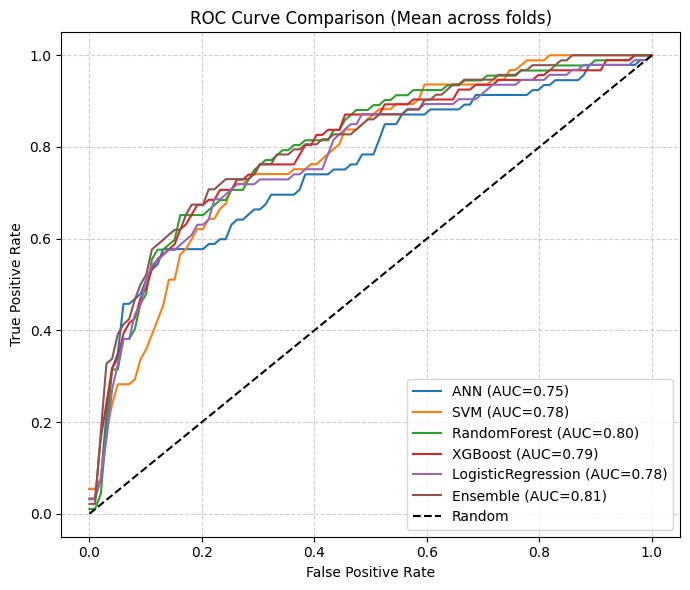

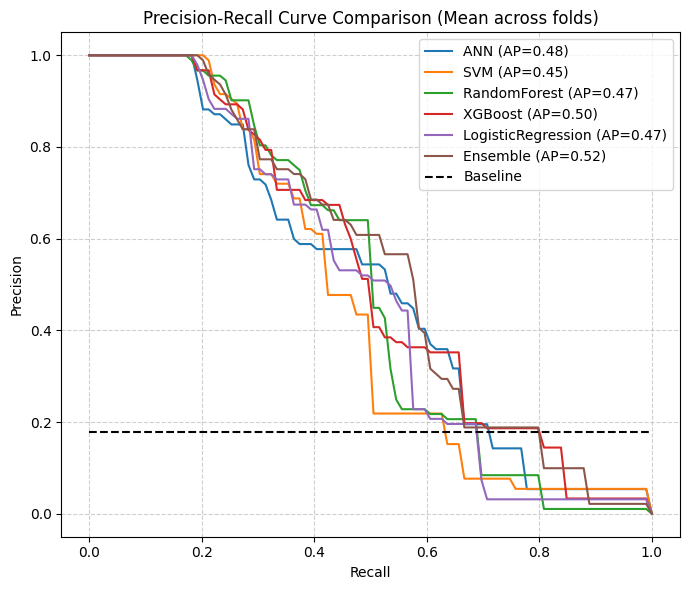

In [279]:
plot_mean_roc(curves_summary, {
    "ANN": deep_metrics,
    "SVM": svm_metrics,
    "RandomForest": rf_metrics,
    "XGBoost": xgb_metrics,
    "LogisticRegression": lr_metrics,
    "Ensemble": ens_metrics
})

plot_mean_pr(curves_summary, {
    "ANN": deep_metrics,
    "SVM": svm_metrics,
    "RandomForest": rf_metrics,
    "XGBoost": xgb_metrics,
    "LogisticRegression": lr_metrics,
    "Ensemble": ens_metrics
})


### Plotting KM Curves

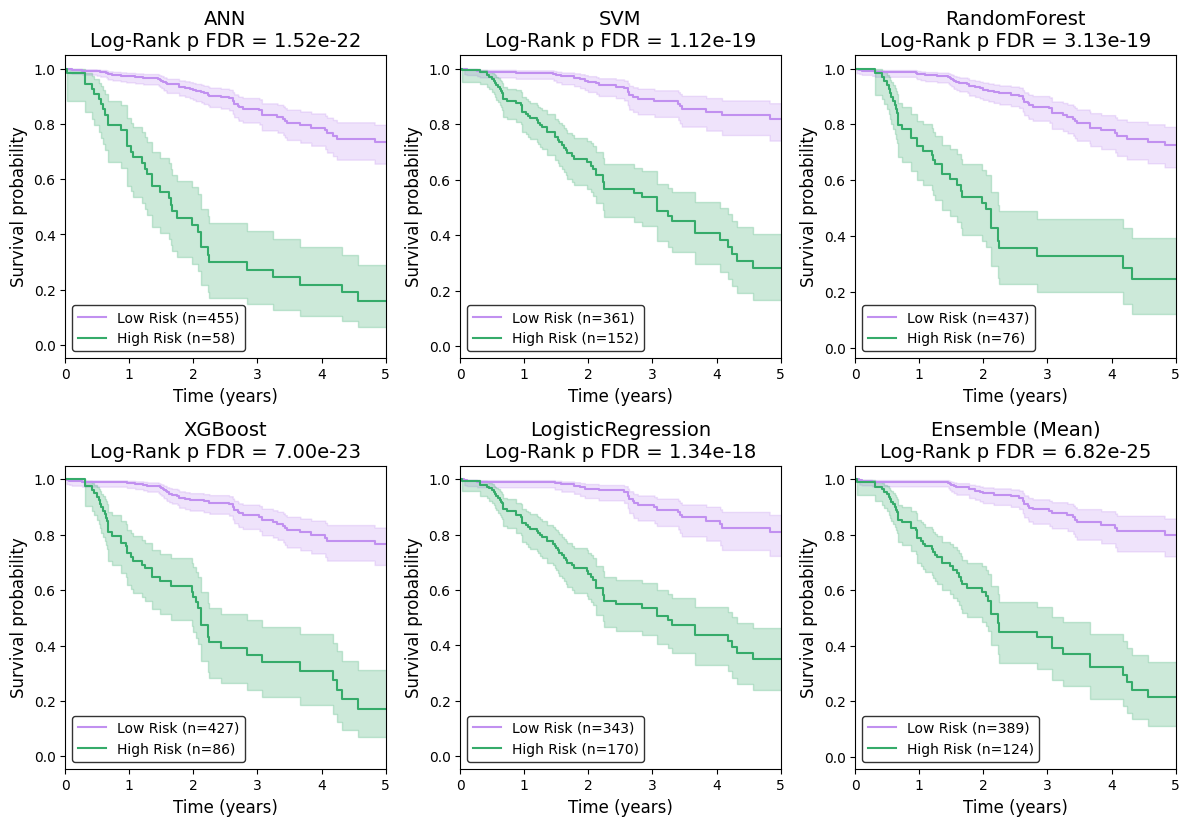

In [280]:
plot_km_curves(survival_results)


In [281]:
print(metrics_summary)

{'ANN': {'accuracy': (0.855701503902532, 0.022868189584102014), 'precision': (0.7046398046398046, 0.170793326077547), 'recall': (0.4152046783625731, 0.1712262326939404), 'f1': (0.48631941535167345, 0.14601976494203175), 'roc_auc': (0.7538615329172604, 0.0364893229194065), 'pr_auc': (0.47775646848966796, 0.05095843447392508)}, 'SVM': {'accuracy': (0.7698458023986293, 0.03157477484844202), 'precision': (0.4171096053704749, 0.04902195566958159), 'recall': (0.687719298245614, 0.14520598549081581), 'f1': (0.513827776202915, 0.06234559259154842), 'roc_auc': (0.7775196160335479, 0.054499429914521044), 'pr_auc': (0.4545200802283892, 0.06228495265650763)}, 'RandomForest': {'accuracy': (0.8283837806967446, 0.026333944190133417), 'precision': (0.5384615384615384, 0.08920748897847211), 'recall': (0.43684210526315786, 0.09206766149755738), 'f1': (0.47437193877683315, 0.0761669098544024), 'roc_auc': (0.7990541713761528, 0.05038065960042535), 'pr_auc': (0.47288324016965333, 0.07328878121788228)}, 'XG

In [282]:
rows = []
for model, metrics in metrics_summary.items():
    row = {"Model": model}
    for metric, (mean_val, std_val) in metrics.items():
        row[f"{metric}_mean"] = mean_val
        row[f"{metric}_std"] = std_val
        rows.append(row)

metrics_df = pd.DataFrame(rows)
metrics_df = metrics_df.drop_duplicates()
metrics_df

,Model,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std,pr_auc_mean,pr_auc_std
0,ANN,0.855702,0.022868,0.704640,0.170793,0.415205,0.171226,0.486319,0.146020,0.753862,0.036489,0.477756,0.050958
6,SVM,0.769846,0.031575,0.417110,0.049022,0.687719,0.145206,0.513828,0.062346,0.777520,0.054499,0.454520,0.062285
12,RandomForest,0.828384,0.026334,0.538462,0.089207,0.436842,0.092068,0.474372,0.076167,0.799054,0.050381,0.472883,0.073289
18,XGBoost,0.836208,0.039478,0.555840,0.103608,0.513450,0.135914,0.525170,0.111691,0.794327,0.057087,0.501628,0.097355
24,LogisticRegression,0.746374,0.065643,0.399891,0.081228,0.719298,0.117353,0.508925,0.083018,0.777348,0.065597,0.470771,0.086288
30,Ensemble,0.808776,0.044749,0.488230,0.083733,0.643860,0.137699,0.546131,0.081755,0.805100,0.060591,0.523512,0.091918


In [283]:
survival_results.keys()

dict_keys(['ANN', 'SVM', 'RandomForest', 'XGBoost', 'LogisticRegression', 'Ensemble (Mean)'])

dict_keys(['ANN', 'SVM', 'RandomForest', 'XGBoost', 'LogisticRegression', 'Ensemble'])


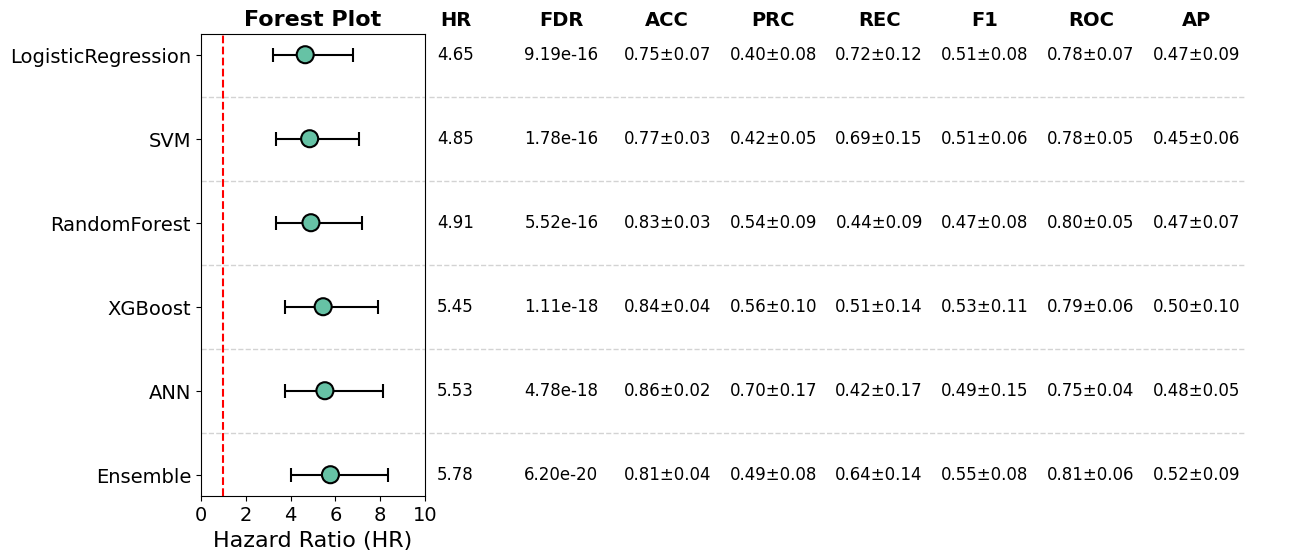

In [284]:
plot_forest(survival_results, metrics_df)

In [285]:
metrics_df.to_csv("./Final_Model_Metrics.csv")